In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/Deepfold2


In [4]:
import h5py
sys.path.append('bin')
from genomic_data import GenomicData

In [6]:
icshape = GenomicData('data/icSHAPE/Lu_2016_invitro/CDS')

In [11]:
from formats import read_fasta
sequences = {}
for name, seq in read_fasta('data/gtf/gencode.v19/sequences/CDS.transcript.fa'):
    if name in icshape.names:
        sequences[name] = np.frombuffer(seq, dtype='S1')

In [18]:
reactivities_concat = np.concatenate([icshape.feature('icshape', name) for name in icshape.names])
sequences_concat = np.concatenate([sequences[name] for name in icshape.names])
notnan_mask = ~np.isnan(reactivities_concat)

In [19]:
import seaborn as sns
sns.set()

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


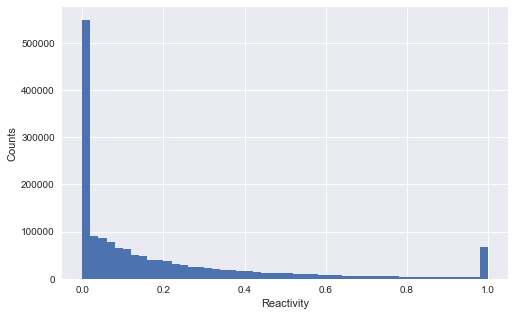

In [20]:
# plot overall distribution of SHAPE reactivity
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(reactivities_concat[notnan_mask], bins=50)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Counts')

(0, 1)

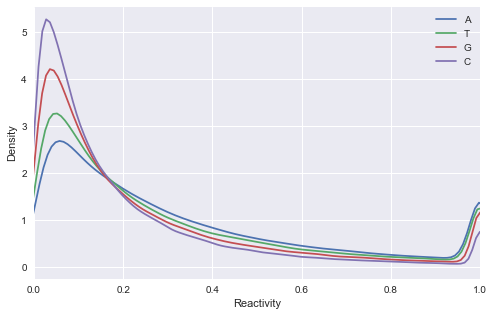

In [27]:
# plot distribution of SHAPE reactivity per nucleotide
fig, ax = plt.subplots(figsize=(8, 5))
for nucleotide in 'ATGC':
    sns.kdeplot(reactivities_concat[notnan_mask & (sequences_concat == nucleotide) & (reactivities_concat != 0)], label=nucleotide, ax=ax)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Density')
ax.set_xlim(0, 1)

In [36]:
# get coverage of every transcript
coverage = []
for name in icshape.names:
    x = icshape.feature('icshape', name)
    coverage.append(float(np.sum(~np.isnan(x)))/x.shape[0])
coverage = np.asarray(coverage)

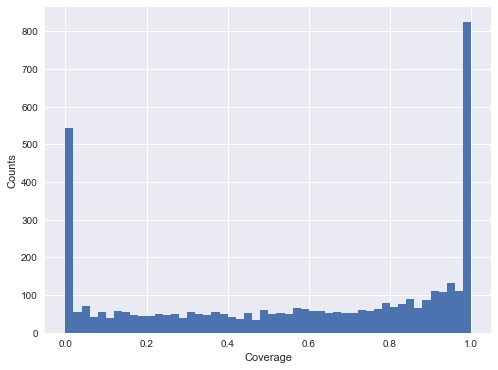

In [39]:
# plot distribution of coverage
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(coverage, bins=50)
ax.set_xlabel('Coverage')
ax.set_ylabel('Counts')

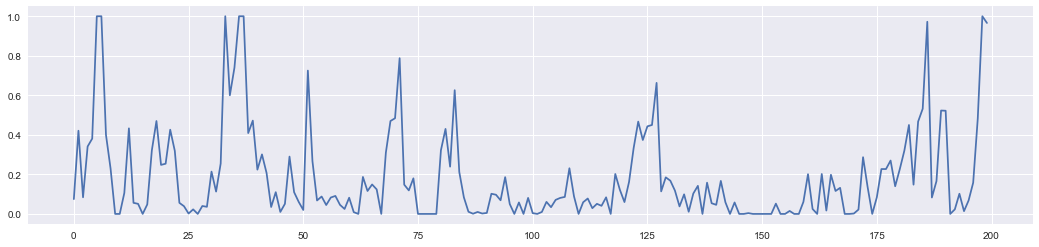

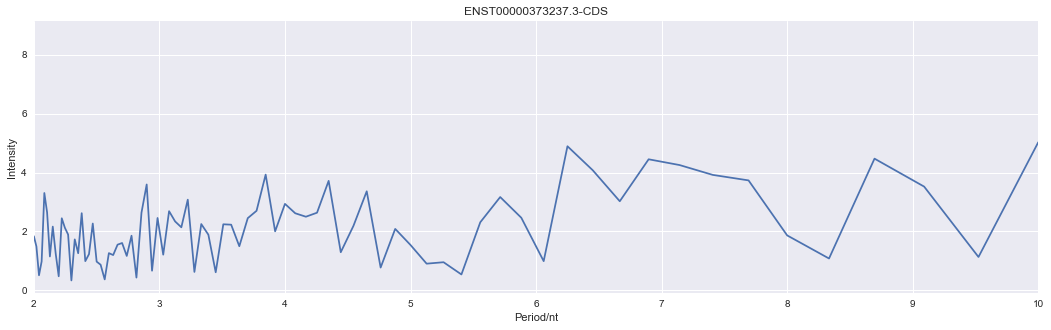

In [139]:
high_coverage_indices = np.argsort(coverage)[::-1]
i = high_coverage_indices[5]
# plot icSHAPE reactivities of one transcript
fig, ax = plt.subplots(figsize=(18, 4))
x = icshape.feature('icshape', icshape.names[i])[:200]
#ax.bar(np.arange(x.shape[0]), x, edgecolor='none')
ax.plot(np.arange(x.shape[0]), x)
plot_fft(x, icshape.names[i])

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in divide


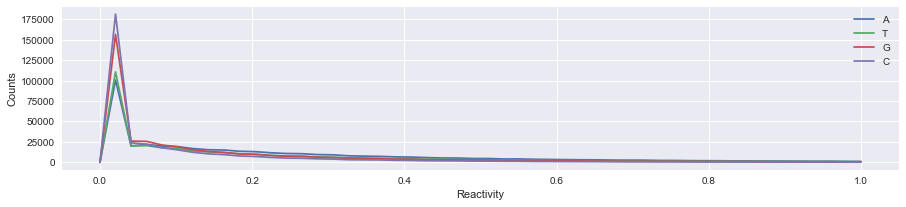

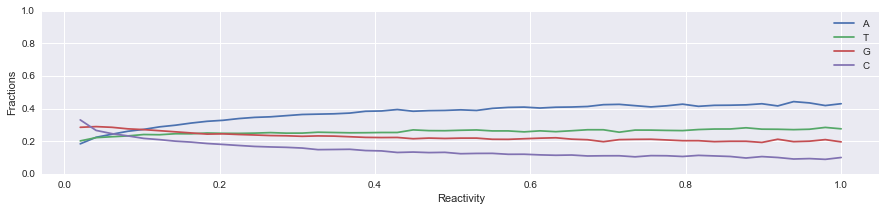

In [158]:
# Nucleotide distribution for each SHAPE reactivity bin
alphabet = np.frombuffer('ATGC', dtype='S1')
sequence_concat_onehot = (sequences_concat[np.newaxis, :] == alphabet[:, np.newaxis]).astype(np.int8)

n_bins = 50
reactivity_bins = np.linspace(0, 1, n_bins, endpoint=True)
bin_indices = np.digitize(reactivities_concat[notnan_mask], reactivity_bins)
reactitity_counts = np.zeros((4, n_bins), dtype=np.int64)
for i in range(n_bins):
    reactitity_counts[:, i] = np.sum(sequence_concat_onehot[:, notnan_mask][:, bin_indices == i], axis=1)
# Create plot
fig, ax = plt.subplots(figsize=(15, 3), sharex=True)
for i, nucleotide in enumerate(alphabet):
    ax.plot(reactivity_bins, reactitity_counts[i], label=nucleotide)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Counts')
plt.legend()
# Normalize counts to fractions
reactivity_fractions = reactitity_counts.astype(np.float64)/np.sum(reactitity_counts, axis=0)
fig, ax = plt.subplots(figsize=(15, 3), sharex=True)
for i, nucleotide in enumerate(alphabet):
    ax.plot(reactivity_bins, reactivity_fractions[i], label=nucleotide)
ax.set_ylim(0, 1)
ax.set_xlabel('Reactivity')
ax.set_ylabel('Fractions')
plt.legend()

(-200, 0)

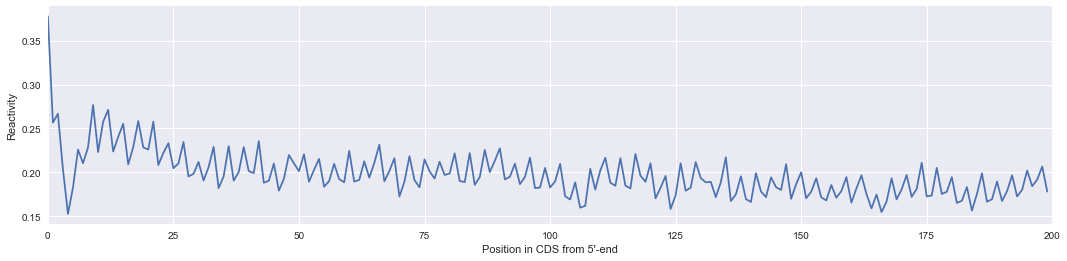

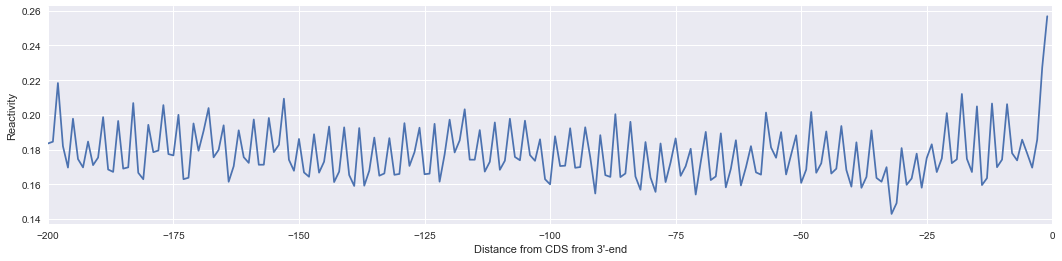

In [68]:
# plot average icSHAPE reactivities across transcripts
sel_names = icshape.names[coverage >= 0.5]
aligned_length = 200

def calc_average_reactivities(direction, aligned_length):
    reactivities_avg = np.full((len(sel_names), aligned_length), np.nan)
    for i, name in enumerate(sel_names):
        x = icshape.feature('icshape', name)
        L = min(x.shape[0], aligned_length)
        if direction == '5p':
            reactivities_avg[i, :L] = x[:L]
        elif direction == '3p':
            reactivities_avg[i, -L:] = x[-L:]
    transcript_counts = np.sum(~np.isnan(reactivities_avg), axis=0)
    reactivities_avg = np.nan_to_num(reactivities_avg)
    reactivities_avg = np.sum(reactivities_avg, axis=0)/transcript_counts.astype(np.float64)
    return reactivities_avg

# 5'-end
reactivities_avg_5p = calc_average_reactivities('5p', aligned_length)
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(np.arange(aligned_length), reactivities_avg_5p)
ax.set_xlabel('Position in CDS from 5\'-end')
ax.set_ylabel('Reactivity')
ax.set_xlim(0, aligned_length)

# 3'-end
reactivities_avg_3p = calc_average_reactivities('3p', aligned_length)
fig, ax = plt.subplots(figsize=(18, 4))
ax.plot(np.arange(-aligned_length, 0), reactivities_avg_3p)
ax.set_xlabel('Distance from CDS from 3\'-end')
ax.set_ylabel('Reactivity')
ax.set_xlim(-aligned_length, 0)

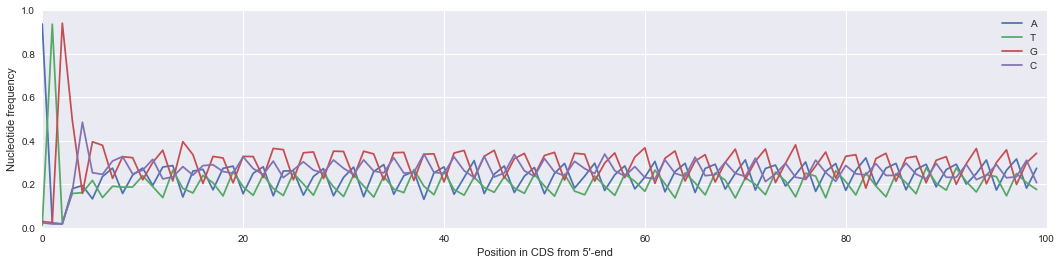

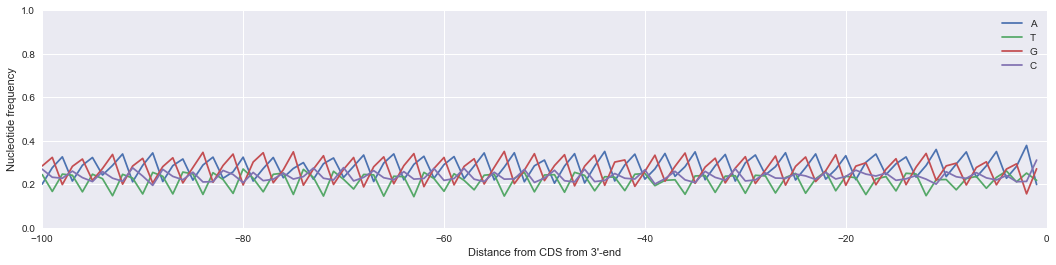

In [154]:
# plot nucleotide frequency at aligned positions
def calc_nucleotide_freq(direction, aligned_length):
    m = np.full((icshape.names.shape[0], aligned_length), 'N', dtype='S1')
    for i, name in enumerate(icshape.names):
        x = sequences[name]
        L = min(x.shape[0], aligned_length)
        if direction == '5p':
            m[i, :L] = x[:L]
        elif direction == '3p':
            m[i, -L:] = x[-L:]
    transcript_counts = np.sum(m != 'N', axis=0)
    m_onehot = (m[:, :, np.newaxis] == alphabet[np.newaxis, np.newaxis, :])
    m_counts = np.sum(m_onehot, axis=0).astype(np.float64)
    m_freq = m_counts/np.sum(m_counts, axis=1)[:, np.newaxis]
    return m_freq

aligned_length = 100
# 5'-end
nucleotide_freq_5p = calc_nucleotide_freq('5p', aligned_length)
fig, ax = plt.subplots(figsize=(18, 4))
for i, nucleotide in enumerate(alphabet):
    ax.plot(np.arange(aligned_length), nucleotide_freq_5p[:, i], label=nucleotide)
ax.set_xlabel('Position in CDS from 5\'-end')
ax.set_ylabel('Nucleotide frequency')
ax.set_xlim(0, aligned_length)
ax.set_ylim(0, 1)
plt.legend()

# 3'-end
nucleotide_freq_3p = calc_nucleotide_freq('3p', aligned_length)
fig, ax = plt.subplots(figsize=(18, 4))
for i, nucleotide in enumerate(alphabet):
    ax.plot(np.arange(-aligned_length, 0), nucleotide_freq_3p[:, i], label=nucleotide)
ax.set_xlabel('Distance from CDS from 3\'-end')
ax.set_ylabel('Nucleotide frequency')
ax.set_xlim(-aligned_length, 0)
ax.set_ylim(0, 1)
plt.legend()

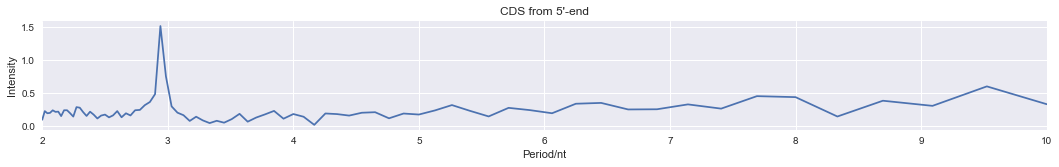

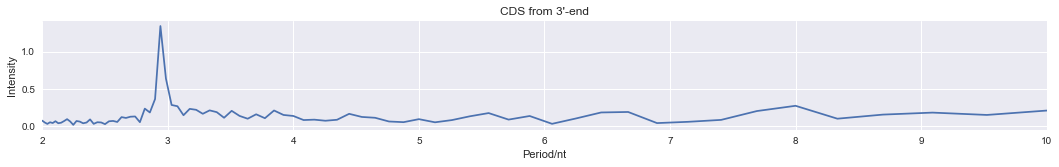

In [156]:
# Fourier transform
from scipy.fftpack import fft
def plot_fft(signals, title):
    N = signals.shape[0]
    yf = fft(signals)
    fig, ax = plt.subplots(figsize=(18, 2))
    period = float(N)/np.arange(1, N//2 + 1)
    ax.plot(period[:1:-1], np.abs(yf[0:yf.shape[0]//2])[:1:-1])
    ax.set_xlim(2, 10)
    ax.set_xlabel('Period/nt')
    ax.set_ylabel('Intensity')
    ax.set_title(title)
plot_fft(reactivities_avg_5p, 'CDS from 5\'-end')
plot_fft(reactivities_avg_3p, 'CDS from 3\'-end')

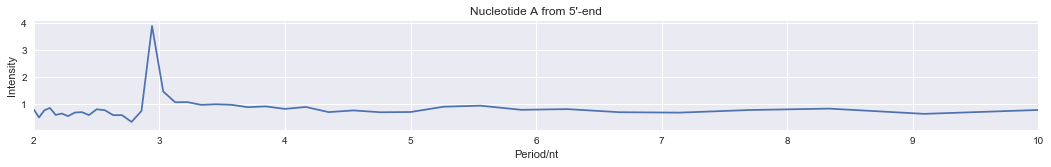

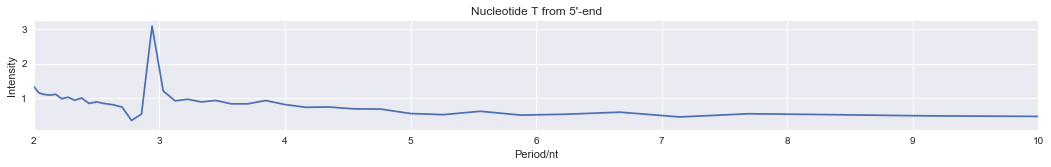

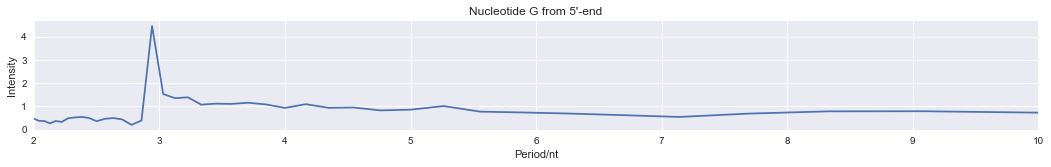

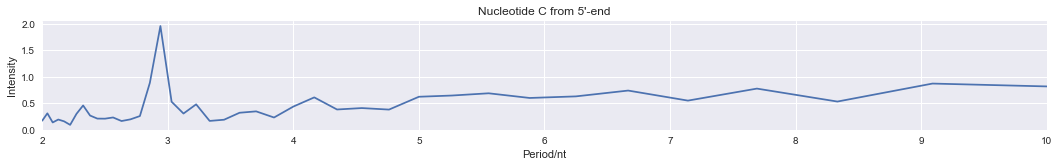

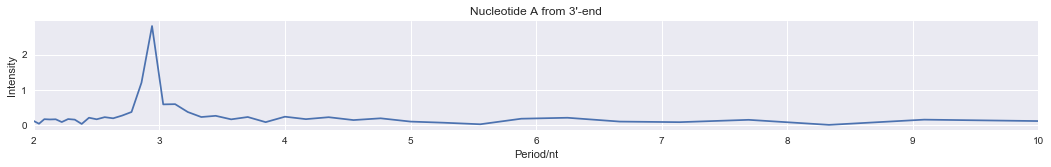

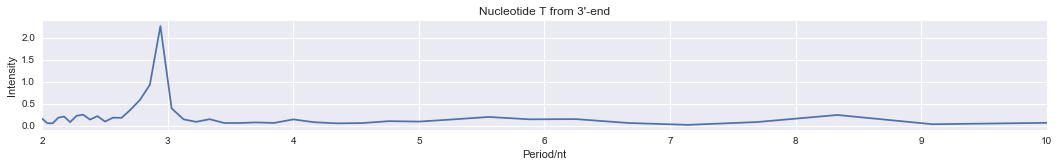

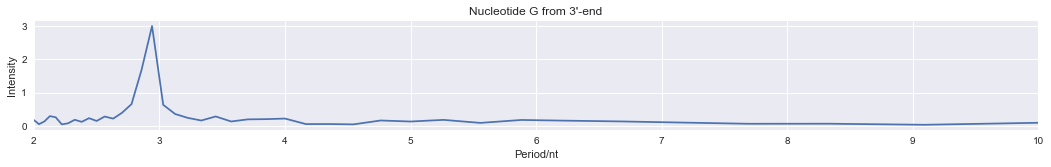

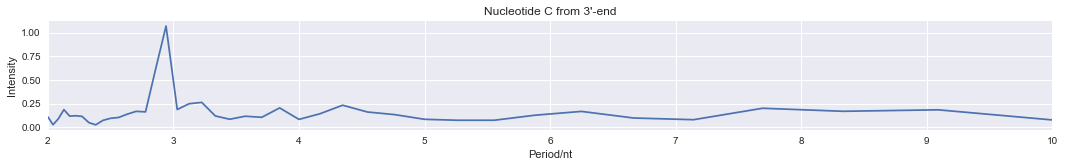

In [157]:
for i, nucleotide in enumerate(alphabet):
    plot_fft(nucleotide_freq_5p[:, i], 'Nucleotide %s from 5\'-end'%nucleotide)
for i, nucleotide in enumerate(alphabet):
    plot_fft(nucleotide_freq_3p[:, i], 'Nucleotide %s from 3\'-end'%nucleotide)